## DATA SOURCE

housing_data_challenge.csv -> Provided by Thomas More

#### Business Goal

For your exam assignment you will build a model to predict housing prices. 

You have to construct a machine learning pipeline (this does not have to be an actual 'scikit-learn pipeline' but can just be consecutive sections in your notebook). Your pipeline features the following items, choose the order yourself but make sure that it is logical and avoids data leakage:

Feature selection
Loading in the dataset
Finding and fixing missing values
Feature engineering (create at least 3 new features)
Cross validation
Random forest model
Tune model parameters

A numeric performance quantification of your model (resulting from cross validation) e.g. RMSE calculation.
A visual performance quantification e.g. a plot of actual vs predicted prices
You upload a jupyter notebook with clear headers and a bit of explanatory text and your conclusions. As there are a large number of items to do, you can be concise. So for example, do not make 10 features as this just adds bulk to your notebook. An other example, demonstrate you can optimise the model parameters but do not optimise them to such an extent that your model takes multiple hours to train, so a bit of optimising is sufficient. etc, I think you understand. Just try to show me that you understand the technique and can use them.

## NB : CROSS VALIDATION TAKES LONG TIME TO RUN, PLEASE GO THROUGH BEFORE RUNNING CELLS.

### LIBRARIES

In [66]:
import warnings

In [67]:
import pandas as pd
from sklearn.feature_selection import RFECV
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import RFE
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Fill in the missing data using SimpleImputer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from boruta import BorutaPy
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
import math
import joblib


# Control how warnings are displayed
warnings.simplefilter("ignore")
import warnings

### UTILITIES FUNCTIONS 

In [68]:
def get_data_directory_path():
    """
        function is used to get path
    """
    ROOT_DIR = os.getcwd()
    # This is to extract the patent directory from the ful path(ETLSystem)
    ROOT_DIR = os.path.dirname(ROOT_DIR)
    DATA_DIR = os.path.join(ROOT_DIR, "Rawdata")

    return DATA_DIR


def draw_histograms(dataframe):
    """
    This method takes a DataFrame and produces histograms for all columns with a normalized line.
    """
    # Get the list of columns in the DataFrame
    columns = dataframe.columns

    # Set up the subplots
    fig, axes = plt.subplots(nrows=len(columns), ncols=1, figsize=(8, 2 * len(columns)))

    # Flatten axes if there's only one column
    if len(columns) == 1:
        axes = [axes]

    # Draw histograms for each column with a normalized line
    for i, column in enumerate(columns):
        sns.histplot(dataframe[column], kde=True, ax=axes[i])
        axes[i].set_title(f'Histogram for {column}')
        axes[i].set_xlabel(column)

    # Adjust layout
    plt.tight_layout()
    plt.show()
    
    
def boxplot(data):
    """
        This method is use to draw a boxplot graph.
    """
    boxplot=data.boxplot(figsize=(12,5))
    
    
def checknumberofmissingdata(data):
    """
        Displays columns with missing values.
    """
    return data.isnull().sum()


def scatterplot(x , y):
    # Create scatter plot
    plt.scatter(x, y)

    # Add labels and title
    plt.xlabel(f'{x}')
    plt.ylabel(f'{y}')
    plt.title(f'Scatter Plot between {x} and {y}')

    # Show the plot
    plt.show()

def correcting_outliers(data, colname):
    """
        methods is use to deal with ouliers and returns the dataframe.it also takes the columname as argument
    """
    q1 = data[colname].quantile(0.25)
    q3 = data[colname].quantile(0.75)
    IQR = q3 - q1
    upper_limit = q3 + (1.5 * IQR)
    lower_limit = q1 - (1.5 * IQR)
    
    # Create a copy of the column to avoid modifying the original data
    corrected_column = data[colname].copy()
    
    # Replace values above the upper limit with the upper limit
    corrected_column.loc[corrected_column > upper_limit] = upper_limit
    
    # Replace values below the lower limit with the lower limit
    corrected_column.loc[corrected_column < lower_limit] = lower_limit
    
    # Update the data with the corrected column
    data[colname] = corrected_column
    
    return data


def one_hot_encode_column(dataframe, column_to_encode):
    # Initialize the OneHotEncoder
    onehot_encoder = OneHotEncoder(sparse=False)
    
    # Extract the column to be one-hot encoded
    data_to_encode = dataframe[[column_to_encode]]
    
    # Fit and transform the data
    onehot_encoded = onehot_encoder.fit_transform(data_to_encode)
    
    # Create a DataFrame with the one-hot encoded columns
    onehot_encoded_df = pd.DataFrame(
        onehot_encoded,
        columns=onehot_encoder.get_feature_names_out([column_to_encode])
    )
    
    # Concatenate the one-hot encoded DataFrame with the original dataset, dropping the original columns
    data_encoded = pd.concat([dataframe, onehot_encoded_df], axis=1).drop(columns=[column_to_encode])
    
    return data_encoded

def find_outliers_iqr(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = (series < lower_bound) | (series > upper_bound)
    return outliers

def plot_histograms_and_box_plots(numeri_col):
    num_cols = len(numeri_col.columns)

    # Set up subplots
    fig, axes = plt.subplots(nrows=2, ncols=num_cols, figsize=(20, 8))
    fig.suptitle('Histograms and Box Plots')

    # Plot histograms and box plots
    for i, col in enumerate(numeri_col.columns):
        # Histogram
        sns.histplot(numeri_col[col], bins=20, kde=True, ax=axes[0, i])
        axes[0, i].set_title(f'{col} - Histogram')

        # Box plot
        sns.boxplot(x=numeri_col[col], ax=axes[1, i])
        axes[1, i].set_title(f'{col} - Box Plot')

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    
def print_top_n_correlations(df, n=7):
    # Calculate the correlation matrix
    correlation_matrix = df.corr()

    # Extract correlations with independent features and exclude self-correlations
    independent_correlations = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))

    # Flatten the correlation matrix and sort in descending order
    flattened_correlations = independent_correlations.unstack().sort_values(ascending=False)

    # Print the top N correlations
    print(f"Top {n} unique correlations between independent features:")
    counter = 0
    for (feature1, feature2), correlation in flattened_correlations.iteritems():
        if not pd.isnull(correlation):  # Exclude NaN values
            print(f"{feature1} - {feature2}: {correlation}")
            counter += 1
            if counter >= n:
                break
                
def cap_outliers_iqr(data):
    if isinstance(data, pd.DataFrame):
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        data_capped = data.apply(lambda x: np.clip(x, lower_bound, upper_bound))
    elif isinstance(data, pd.Series):
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        data_capped = np.clip(data, lower_bound, upper_bound)
    else:
        raise ValueError("Input must be a DataFrame or a Series.")
    
    return data_capped

### Documentation of  fuctions 

### Utility Functions
- `draw_histograms(dataframe)`: produce histogram for all columns in the dataframe.
- `boxplot(data)`: use to draw boxplot graph.
- `checknumberofmissingdata(data)`: displays all missing values.
- `scatterplot(x , y)`: use to draw scatterplot graph.
- `correcting_outliers(data, colname)`: use to remove outliers using IQR, replacing outliers with upper and lower limits.
- `one_hot_encode_column(dataframe, column_to_encode)`: use in encoding columns that are cartegorical and returns the entire data.
- `find_outliers_iqr(series)`: Function to identify outliers using IQR.
- `plot_histograms_and_box_plots(numeri_col)`: Function is use to plot histogram and box-plot of every numerical columns.


### READING IN THE DATA

In [69]:
housingdata_df = pd.read_csv("housing_data_challenge.csv" , sep =";")

In [113]:
housingdata_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-121.25,37.95,40.0,1703.0,362.0,1208.0,373.0,2.0817,55300.0,INLAND
1,-116.00,34.12,32.0,3163.0,712.0,1358.0,544.0,2.1250,57700.0,INLAND
2,-116.48,33.61,8.0,1294.0,272.0,457.0,199.0,2.9167,115300.0,INLAND
3,-122.60,38.90,23.0,292.0,56.0,92.0,41.0,2.9583,91700.0,INLAND
4,-121.30,38.58,29.0,2748.0,563.0,1619.0,525.0,2.8966,92400.0,INLAND


### META DATA:  

### A. EDA (EXPLORATORY DATA ANALYSIS)

In this section I am going to perform an exploratory data analysis on our data set so as to get insight of our data set, check on irregularities and understand pattern between inputs and output if any so as to prepare us for preprocessing and model building phase for our project.

In [71]:
class EDA:
    """
        This is a class for exploratory data analysis with methods for exploring the data
    """
    def __init__(self, extractedtext):
        self.extractedtext = extractedtext

    def aboutdata(self): 
        return self.extractedtext.info()

    def summarystatistic(self):
        return self.extractedtext.describe()

    def shapeofdataframe(self):
        return self.extractedtext.shape
    
    def datatypesofdifferentcol(self):
        return self.extractedtext.dtypes

    def correlation_heatmap(self):
        correlation_matrix = self.extractedtext.corr()
        # Set the size of the graph
        plt.figure(figsize=(14, 10))
        # Create a heatmap
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
        # Add title
        plt.title('Correlation Heatmap')
        plt.show()
        
    def correlationbetweenoutputandinput(self):
        return self.extractedtext.corr()['median_house_value'].sort_values()

    def histogram_with_kde(self):
        sns.distplot(self.extractedtext['median_house_value'], hist=True, kde=True,
                     bins=int(30), color='darkblue',
                     hist_kws={'edgecolor': 'black'},
                     kde_kws={'linewidth': 2})
        plt.title(f'Distribution of target')
        plt.xlabel('target')
        plt.ylabel('Density')
        plt.show()

#### Creating an object of our class EDA

In [72]:
EDAObject = EDA(housingdata_df)

#### 1.0 Information about the dataframea

In [73]:
print(EDAObject.aboutdata())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18576 entries, 0 to 18575
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           18576 non-null  float64
 1   latitude            18576 non-null  float64
 2   housing_median_age  18576 non-null  float64
 3   total_rooms         18576 non-null  float64
 4   total_bedrooms      18388 non-null  float64
 5   population          18576 non-null  float64
 6   households          18576 non-null  float64
 7   median_income       18576 non-null  float64
 8   median_house_value  18576 non-null  float64
 9   ocean_proximity     18576 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.4+ MB
None


Housing_data has a total of 18576 observations and 10 features. (longitude, latitude ,housing_median_age, total_rooms, total_bedrooms, population, households,median_income and median_house_value) has datatype float64 while ocean_proximity has datatype object.
total_bedrooms has 18388 entries which is less than the maximum entry recorded in other features, we need to investigate why and also fix this in our preparation phase.

#### 1.1 Summary statistics

In [74]:
EDAObject.summarystatistic()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,18576.000000,18576.000000,18576.000000,18576.000000,18388.000000,18576.000000,18576.000000,18576.000000,18576.000000
mean,-119.563730,35.627052,28.657192,2633.559916,537.537524,1424.686746,498.951820,3.876364,206864.619671
std,2.001352,2.134321,12.614083,2175.784573,420.993441,1132.373751,381.328659,1.908169,115448.691679
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.780000,33.930000,18.000000,1444.000000,295.000000,788.000000,279.000000,2.564300,119400.000000
50%,-118.490000,34.250000,29.000000,2129.000000,434.500000,1167.000000,409.000000,3.534800,179700.000000
75%,-118.000000,37.710000,37.000000,3145.000000,645.000000,1724.000000,604.000000,4.750000,264700.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


 From the summary statistcs we can get the following observation : 
    - longitude : The mininmum value is -124.350000 and maximum value is -114.310000. The mean is -119.563730 and it has a low standard deviation from the mean value, means this feature is good and has no outliers or irregularity. 
    
    - latitude 	: The mininmum value is 32.540000 and maximum value is 41.950000. The mean is 35.627052  and it has a low standard deviation from the mean value, means this feature is good and has no outliers or irregularity. 
    
    - housing_median_age : The mininmum value is 1.000000  and maximum value is 41.950000. The mean is 52.000000  and it has a low standard deviation from the mean value, means this feature is good and has no outliers or irregularity. 
   
    - total_rooms : The mininmum value is 2.000000  and maximum value is 39320.000000. The mean is 2633.559916  and it has a high standard deviation from the mean value, means this feature has some irregularities and has to be investigated and fixed.
   
    - total_bedrooms : The mininmum value is 1.000000  and maximum value is 6445.000. The mean is 420.993441  and it has a high standard deviation from the mean value, means this feature has some irregularities and has to be investigated and fixed.
    
    - population : The mininmum value is 3.000000 and maximum value is 35682.000000. The mean is 1424.686746 and it has a high standard deviation from the mean value, means this feature has some irregularities and has to be investigated and fixed.
    
    - median_income : The mininmum value is 0.499900 and maximum value is 15.000100. The mean is 3.876364 and it has a high standard deviation from the mean value, means this feature has some irregularities and has to be investigated and fixed.
    
    - households :  The mininmum value is 1.000000 and maximum value is 6082.000000. The mean is 381.328659 and it has a high standard deviation from the mean value, means this feature has some irregularities and has to be investigated and fixed.

#### 1.2 Shape of the dataframe

In [75]:
print(EDAObject.shapeofdataframe())

(18576, 10)


#### 1.3 Correlation - >Heatmap

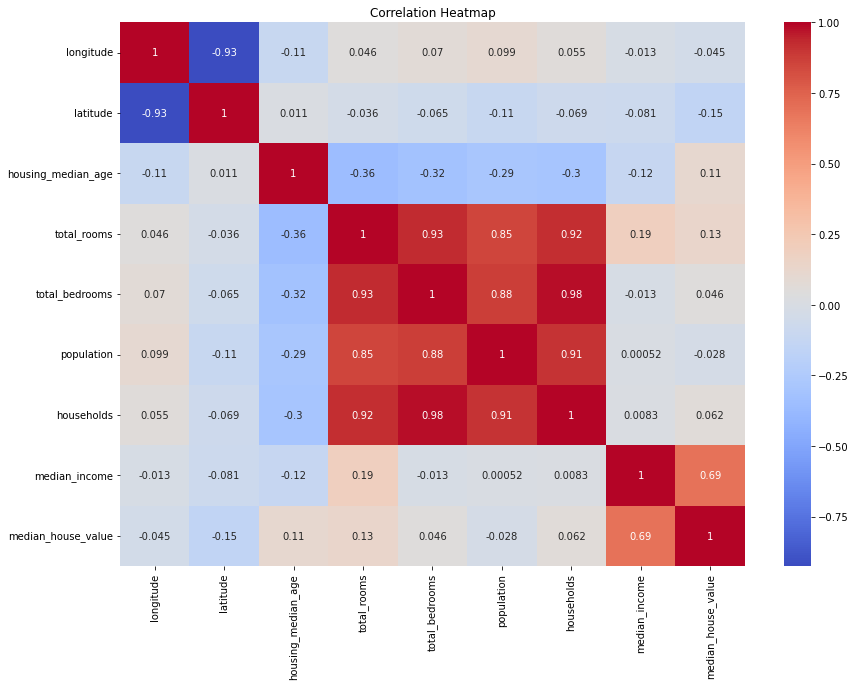

In [76]:
EDAObject.correlation_heatmap()

In [77]:
print(EDAObject.correlationbetweenoutputandinput())

latitude             -0.145129
longitude            -0.044562
population           -0.027507
total_bedrooms        0.045861
households            0.062386
housing_median_age    0.105739
total_rooms           0.131598
median_income         0.688631
median_house_value    1.000000
Name: median_house_value, dtype: float64


After performing correlation analysis between all feature, here are my findings: 
    -> Mean_income has a strong positve correlation with the predicted varibale median_house_value.
    -> total_rooms , housing_median_age, households and total_bedrooms has a weak positive correlation with the predicted varibale median_house_value.
    -> latitude ,longitude and population has a weak negative correlation with the predicted varibale median_house_value.

In [78]:
numerical_col = housingdata_df.drop(['ocean_proximity'] , axis = 1)

In [79]:
print_top_n_correlations(numerical_col, n=7)

Top 7 unique correlations between independent features:
households - total_bedrooms: 0.9789172813928351
total_bedrooms - total_rooms: 0.9299250315978743
households - total_rooms: 0.9175261533661458
households - population: 0.9061464139611632
population - total_bedrooms: 0.8753221645240294
population - total_rooms: 0.8546958922986058
median_house_value - median_income: 0.6886309170981911


we see that there exist some correlation between the independent variable.With this information we can use in our feature selection to decide which feature can be remove base on it relevance and effects to our dependent variable.

#### 1.4 Histogram of output  and some inputs

###### -> OUTPUT AND INPUT

In this section we would see histgram of all the numerical feature and a boxplots of each feature, with this we can see Normalization of each feature giving further information about the exitence of outliers which needs to be treated before feeding our data set to our model.

In [80]:
numerical_col = housingdata_df.drop(['ocean_proximity'] , axis = 1)

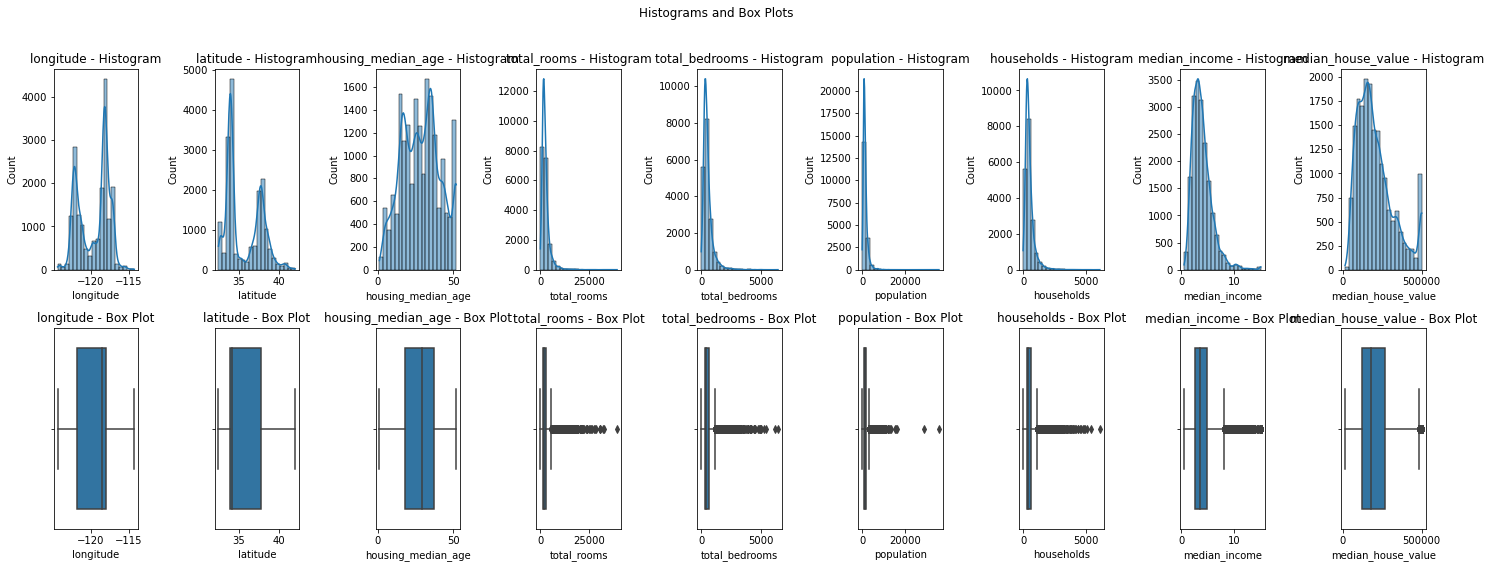

In [81]:
plot_histograms_and_box_plots(numerical_col)

From the above histogram, we can see that total_rooms, total_bedrooms, population, households and median_income are rightly skwed and this is possibly as a result of outliers in these features.
For the median_house_value we can see it it slighly rightly skwed and has some outliers aswell.
This can also be seen in the box plot bellow each plots, hence futher explain our observations in the summary statistics above.

## Concludsion -> EDA

From our EDA we observe the following : 
    - some feature has missing values - > total_bedrooms 
    - some feature has outliers - > ['total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
    - some features were strongly correlated to our dependent variable.
    - some features were strongly correlated with each other.
    - one cartegorical variable -> ocean_proximity

### B. DATA PREPROCESSING

In this section we will be dealing with preprocesing of our data set. This is a very important step in our machine learning project because anything we train or feed our model with can affect the outcome. We will be check for missing values, duplicates rows and outliers.

In [82]:
class Preprocessing:
    """
     This class is use to preprocessing of the data, initial preprocess with methods for preprocessing.
    """
    
    def __init__(self , data):
        self.data = data
    
    def checkforduplicatesrows(self):
        return self.data.duplicated().sum()
    
    def checkformissingvalues(self):
        return self.data.isnull().sum()
    
    def dealingwithduplicatedrows(self):
        return self.data.drop_duplicates(inplace=True)
        
    def dealingwithincorrectcol(self):
        datawithnomissingvalues = self.dealingwithduplicatedrows()
        
    def dealingwithoutliers(self):
        cleandata = self.dealingwithincorrectcol()
        for column in cleandata:
            m1=cleandata[column].quantile(0.50)
            p1=cleandata[column].quantile(0.95)
            cleandata[column] = np.where(cleandata[column] > p1, m1, cleandata[column])

#### Creating an object of our class Preprocessing

In [83]:
preprocessingobject = Preprocessing(housingdata_df)

#### 2.1 Checking for duplicated rows

In [84]:
preprocessingobject.checkforduplicatesrows()

0

#### 2.1.1 Dealing with duplicated rows

In [85]:
#preprocessingobject.dealingwithduplicatedrows()

Since they are no duplicated observations, we do no need to remove duplicate observation(entries) for our dataset.

#### 2.2 Checking for incorrect data in each columns and dealing with them

In [86]:
housingdata_df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [87]:
housingdata_df['housing_median_age'].unique()

array([40., 32.,  8., 23., 29., 13., 39., 33.,  7., 19., 28., 16., 24.,
       35.,  9., 31., 22., 52.,  4., 30., 25., 26., 43., 21., 37., 41.,
       11., 14., 36., 34., 49., 10., 20.,  6., 51., 38., 45., 18., 17.,
       42., 27., 47.,  3., 15., 44.,  5., 46., 12.,  2., 48., 50.,  1.])

After checking each features and see their different values, i noticed consistency in every feature base on their data type. hence we don't have to deal with any incorrect data for our data set. 

#### 2.3 Checking for missing values

In [88]:
preprocessingobject.checkformissingvalues()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        188
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

Like as seen in the EDA, i noticed that they where missing data in our data set, total_bedroom has 188 missing data and we need to fix this before we build our model.

==> DATA LEAKAGE : To avoid data leakage in our data set, we need to split our data set into train and test data set before handling missig values and outliers. 

#### 2.4 Checking for outliers

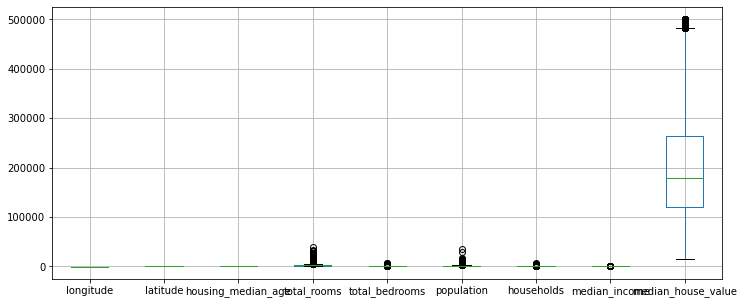

In [89]:
boxplot(numerical_col)

In [90]:
# Identify outliers for each feature
outliers_dict = {}
for column in numerical_col.columns:
    outliers_dict[column] = find_outliers_iqr(numerical_col[column])

In [91]:
# Display features with outliers
features_with_outliers = [feature for feature, has_outliers in outliers_dict.items() if has_outliers.any()]
print("Features with Outliers:", features_with_outliers)

Features with Outliers: ['total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']


#### 2.5 Encoding the feature - > ocean_proximity

In [92]:
## because i don't want to change my original data set, i will create a copy of my data and use it for preprocessing 
preprocessed_data = housingdata_df.copy()

In [93]:
encoded_data = one_hot_encode_column(preprocessed_data, 'ocean_proximity')

In [94]:
encoded_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-121.25,37.95,40.0,1703.0,362.0,1208.0,373.0,2.0817,55300.0,0.0,1.0,0.0,0.0,0.0
1,-116.00,34.12,32.0,3163.0,712.0,1358.0,544.0,2.1250,57700.0,0.0,1.0,0.0,0.0,0.0
2,-116.48,33.61,8.0,1294.0,272.0,457.0,199.0,2.9167,115300.0,0.0,1.0,0.0,0.0,0.0
3,-122.60,38.90,23.0,292.0,56.0,92.0,41.0,2.9583,91700.0,0.0,1.0,0.0,0.0,0.0
4,-121.30,38.58,29.0,2748.0,563.0,1619.0,525.0,2.8966,92400.0,0.0,1.0,0.0,0.0,0.0


#### 2.6 Feature engineering

##### a.Income per Capita

In [95]:
encoded_data['income_per_capita'] = encoded_data['median_income'] / encoded_data['population']

##### b.Rooms per Household

In [96]:
encoded_data['rooms_per_household'] = encoded_data['total_rooms'] / encoded_data['households']

##### b.Population per Household

In [97]:
encoded_data['population_per_household'] = encoded_data['population'] / encoded_data['households']

In [98]:
encoded_data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,income_per_capita,rooms_per_household,population_per_household
0,-121.25,37.95,40.0,1703.0,362.0,1208.0,373.0,2.0817,55300.0,0.0,1.0,0.0,0.0,0.0,0.001723,4.565684,3.238606
1,-116.00,34.12,32.0,3163.0,712.0,1358.0,544.0,2.1250,57700.0,0.0,1.0,0.0,0.0,0.0,0.001565,5.814338,2.496324
2,-116.48,33.61,8.0,1294.0,272.0,457.0,199.0,2.9167,115300.0,0.0,1.0,0.0,0.0,0.0,0.006382,6.502513,2.296482
3,-122.60,38.90,23.0,292.0,56.0,92.0,41.0,2.9583,91700.0,0.0,1.0,0.0,0.0,0.0,0.032155,7.121951,2.243902
4,-121.30,38.58,29.0,2748.0,563.0,1619.0,525.0,2.8966,92400.0,0.0,1.0,0.0,0.0,0.0,0.001789,5.234286,3.083810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18571,-119.57,36.10,36.0,1729.0,317.0,737.0,278.0,3.5313,68800.0,0.0,1.0,0.0,0.0,0.0,0.004791,6.219424,2.651079
18572,-117.27,34.10,9.0,3904.0,1042.0,3688.0,896.0,1.8022,78000.0,0.0,1.0,0.0,0.0,0.0,0.000489,4.357143,4.116071
18573,-118.27,34.11,39.0,3825.0,916.0,1378.0,746.0,4.4094,352600.0,1.0,0.0,0.0,0.0,0.0,0.003200,5.127346,1.847185
18574,-117.97,34.07,22.0,1438.0,364.0,1325.0,335.0,2.7802,162500.0,1.0,0.0,0.0,0.0,0.0,0.002098,4.292537,3.955224


#### 2.7 Feature selection base on correlation of independent variable 

Just as seen above in our EDA, we can see the the feature total_bedrooms is strongly correlated with many independent features, and it has a comparatively weak correlation with the dependent variable and also in the context of real estate bedroom is a subset of room which is already a feature in our data set. Therefore i will drop this feature.

In [99]:
encoded_data = encoded_data.drop(['total_bedrooms'] , axis = 1)

In [100]:
encoded_data.head(5)

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,income_per_capita,rooms_per_household,population_per_household
0,-121.25,37.95,40.0,1703.0,1208.0,373.0,2.0817,55300.0,0.0,1.0,0.0,0.0,0.0,0.001723,4.565684,3.238606
1,-116.00,34.12,32.0,3163.0,1358.0,544.0,2.1250,57700.0,0.0,1.0,0.0,0.0,0.0,0.001565,5.814338,2.496324
2,-116.48,33.61,8.0,1294.0,457.0,199.0,2.9167,115300.0,0.0,1.0,0.0,0.0,0.0,0.006382,6.502513,2.296482
3,-122.60,38.90,23.0,292.0,92.0,41.0,2.9583,91700.0,0.0,1.0,0.0,0.0,0.0,0.032155,7.121951,2.243902
4,-121.30,38.58,29.0,2748.0,1619.0,525.0,2.8966,92400.0,0.0,1.0,0.0,0.0,0.0,0.001789,5.234286,3.083810


## Concludsion - > Preprocessing :


During the preprocessing phase the following was done : 
    - No duplicates was seen on our data set.
    - I remove a feature base on correlation. 
    - not much was done in outliers and missing values because we don't want data leakage and contamination, this would be done in cross validation part in building our model 

# C. OULTLIER CLEANING , NORMALIZATION OF DATA SET, FEATURE SELECTION AND GRID SEARCH

#### N:B - kfold takes a long time to run because of large dataset
In this part i did the following : 
- K-fold cross validation , k=5.
- data preprocessing , outlier treatment(caping) , normalization using standardscaler() and feature selections using (RFECV).
- I use Gridsearchcv to find the best parameter for my model. 
- Evaluate my model using ((MSE) , (MAE) , R-squared (R2) , Explained Variance Score and Mean Squared Logarithmic Error (MSLE))



In [103]:
# Step 2: Splitting the data into features and target
X = encoded_data.drop("median_house_value", axis=1)
y = encoded_data["median_house_value"]

# Step 4: Setting up the pipeline with RandomForestRegressor
rf_reg = RandomForestRegressor(random_state=42)

# Step 5: Creating the pipeline with RFECV
pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), X.columns),
        ],
        remainder='passthrough'
    ),
    RFECV(estimator=rf_reg, step=10, cv=5 , min_features_to_select=8),  # RFECV for feature selection
    rf_reg
)

In [104]:
# Step 6: Setting up the parameter grid for GridSearchCV
param_grid = {
    'randomforestregressor__n_estimators': [50, 100, 200],
    'randomforestregressor__max_depth': [None, 10, 20],
    'randomforestregressor__min_samples_split': [2, 5, 10],
    'randomforestregressor__min_samples_leaf': [1, 2, 4]
}

# Step 7: Setting up GridSearchCV with parallel processing
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1  # Use all available CPU cores
)

In [105]:
# Step 8: Fitting the model within a K-fold cross-validation loop
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Step 9: Capping outliers using IQR for X_train
    Q1_X_train = X_train.quantile(0.25)
    Q3_X_train = X_train.quantile(0.75)
    IQR_X_train = Q3_X_train - Q1_X_train
    lower_bound_X_train = Q1_X_train - 1.5 * IQR_X_train
    upper_bound_X_train = Q3_X_train + 1.5 * IQR_X_train
    X_train = np.clip(X_train, lower_bound_X_train, upper_bound_X_train, axis=1)

    # Step 10: Capping outliers using IQR for X_test
    Q1_X_test = X_test.quantile(0.25)
    Q3_X_test = X_test.quantile(0.75)
    IQR_X_test = Q3_X_test - Q1_X_test
    lower_bound_X_test = Q1_X_test - 1.5 * IQR_X_test
    upper_bound_X_test = Q3_X_test + 1.5 * IQR_X_test
    X_test = np.clip(X_test, lower_bound_X_test, upper_bound_X_test, axis=1)

    # Step 11: Capping outliers using IQR for y_train
    Q1_y_train = y_train.quantile(0.25)
    Q3_y_train = y_train.quantile(0.75)
    IQR_y_train = Q3_y_train - Q1_y_train
    lower_bound_y_train = Q1_y_train - 1.5 * IQR_y_train
    upper_bound_y_train = Q3_y_train + 1.5 * IQR_y_train
    y_train = np.clip(y_train, lower_bound_y_train, upper_bound_y_train)

    # Step 12: Capping outliers using IQR for y_test
    Q1_y_test = y_test.quantile(0.25)
    Q3_y_test = y_test.quantile(0.75)
    IQR_y_test = Q3_y_test - Q1_y_test
    lower_bound_y_test = Q1_y_test - 1.5 * IQR_y_test
    upper_bound_y_test = Q3_y_test + 1.5 * IQR_y_test
    y_test = np.clip(y_test, lower_bound_y_test, upper_bound_y_test)

    # Step 13: Fitting the grid search on the preprocessed data
    grid_search.fit(X_train, y_train)

    # Print the best estimator
    print("Best Estimator:", grid_search.best_estimator_)

    # Step 14: Evaluating the best estimator on the test set without outliers
    y_pred = grid_search.best_estimator_.predict(X_test)

    # Calculate and print additional evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    explained_var = explained_variance_score(y_test, y_pred)
    msle = mean_squared_log_error(y_test, y_pred)

    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R-squared (R2): {r2}")
    print(f"Explained Variance Score: {explained_var}")
    print(f"Mean Squared Logarithmic Error (MSLE): {msle}")

Best Estimator: Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'population', 'households', 'median_income',
       'ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN', 'income_per_capita',
       'rooms_per_household', 'population_per_household'],
      dtype='object'))])),
                ('rfecv',
                 RFECV(cv=5, estimator=RandomForestRegressor(random_state=42),
                       min_features_to_select=8, step=10)),
                ('randomforestregressor',
                 RandomForestRegressor(min_samples_leaf=2, n_estimators=200,
                                       random_state=42))])
Mean Squared Error (MSE): 2425

## Observation from the K-fold cross validation 

#### Checking if outliers was dealt with

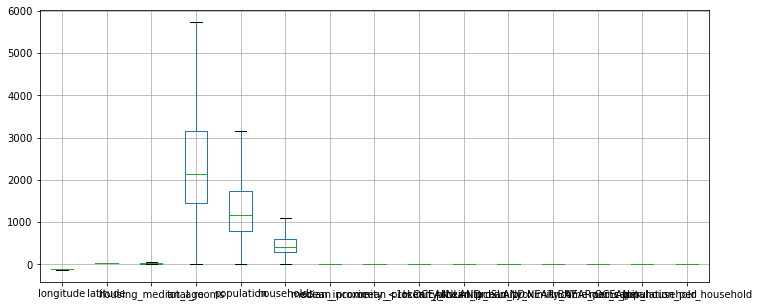

In [106]:
boxplot(X_train)

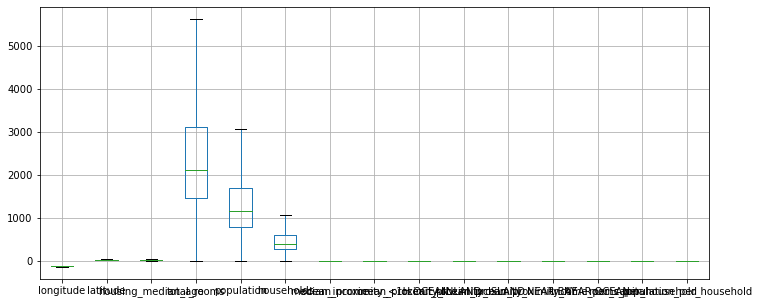

In [107]:
boxplot(X_test)

## Plot of Actual and Predicted values : 

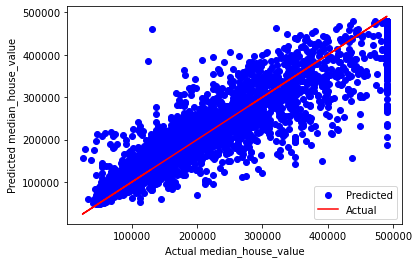

In [108]:
plt.scatter(y_test, y_pred, label='Predicted', color='blue')  # Predicted values in blue
plt.plot(y_test, y_test, label='Actual', color='red')  # Actual values in red

plt.xlabel("Actual median_house_value")
plt.ylabel("Predicted median_house_value")
plt.legend()  # Show legend to differentiate between actual and predicted values
plt.show()

## Dataframe of Actual and Predicted values : 

In [109]:
y_test_array = np.array(y_test)
y_pred_array = np.array(y_pred)

df_results = pd.DataFrame({
    'Actual (y_test)': y_test_array,
    'Predicted (y_pred)': y_pred_array
})

In [110]:
df_results.head()

,Actual (y_test),Predicted (y_pred)
0,281300.0,289160.579563
1,490850.0,340055.341865
2,217800.0,260414.747619
3,225000.0,211735.060516
4,366200.0,416598.993155


## D. MODEL DEPLOYMENT FOR STREAMLIT APPLICATION

In [51]:
!pip install joblib

In [53]:
# Save the model to a file
model_filename = 'RF_model.joblib'
joblib.dump(rf_reg, model_filename)

['RF_model.joblib']

## FINAL CONCLUDSION 

The objective of the project was developing a robust predictive moedle that coule be use to predict the median_house_value. I  use random forest regressor to do this and it was integrated into a feature selection pipeline. The project involves the following steps: 
- Exploratory Data Analysis. 
- Preprocesssing. 
- model building. 
- deployment of my model.
We employed a pipeline that incorporated a ColumnTransformer for feature scaling and a Recursive Feature Elimination with Cross-Validation (RFECV) to automatically select the most relevant features. The Random Forest Regressor served as our predictive model, and we fine-tuned its hyperparameters using an exhaustive GridSearchCV.

After fitting the model withing a k-fold cross-validation loop, we evaluated the perfomance on multiple test sets and use the best estimator from our grid search which demonstrated a very strong predictive capabilities.
The R2 was around 0.81 indicating that about 81% of the variance of the median_house_value. was explain by my model and also good for unseen data.